# CS 617 - Data Mining

## Homework 1 - Problem 3

In this notebook, we'll see gradient descent in action. The code in this notebook is not designed to be *fast*, but instead *easy to understand*.

We'll get started by importing the familiar Python numerical and plotting packages, `numpy` and `matplotlib`.

For your homework, you need to fill-in where you see # YOUR IMPLEMENTATION IS HERE

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.animation as animation
import ipywidgets

plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = [12, 8]
mpl.rcParams['animation.html'] = 'jshtml'

## 1. Code for Gradient Descent

First, we'll code up a general gradient descent function. The code below implements gradient descent as seen in lecture.

In [2]:
def gradient_descent(
        derivative_of_f, *, h_0, alpha, max_iter=10_000, tol=1e-12, verbose=False
    ):
    """Minimize a (univariate) function f using gradient descent.
    
    Parameters
    ----------
    derivative_of_f : callable
        A function which accepts one argument, h, and outputs the derivative
        of f at h.
    h_0 : float
        The initial guess of the minimizer.
    alpha : float
        The step size parameter.
    max_iter : int
        The maximum number of steps to take.
    tol : float
        The convergence tolerance. If the difference between subsequent guesses
        is less than tol, the algorithm will assume that it has converged.
    verbose : bool
        If `True`, prints the progress of the search.
    """
    verbose = True
    while verbose:
        h_next = h_0 - alpha * derivative_of_f(h_0)
        if abs(h_next - h_0) < tol:
            verbose = False
            break
        h_0 = h_next
    return h_0

## 2. StackOverflow Salary Data

Let's go back to the problem of predicting a data scientist's salary. We'll do this by minimizing empirical risk with gradient descent.

First, we'll load the data with `pandas`:

In [3]:
import pandas as pd
SALARIES = pd.read_csv('data_scientist_salaries.csv').get('Salary').values
SALARIES

array([120000., 120000.,  70000., ..., 149000.,  57000.,  50000.])

In [4]:
len(SALARIES)

1121

To get an idea of how the salaries are distributed, we'll plot a histogram:

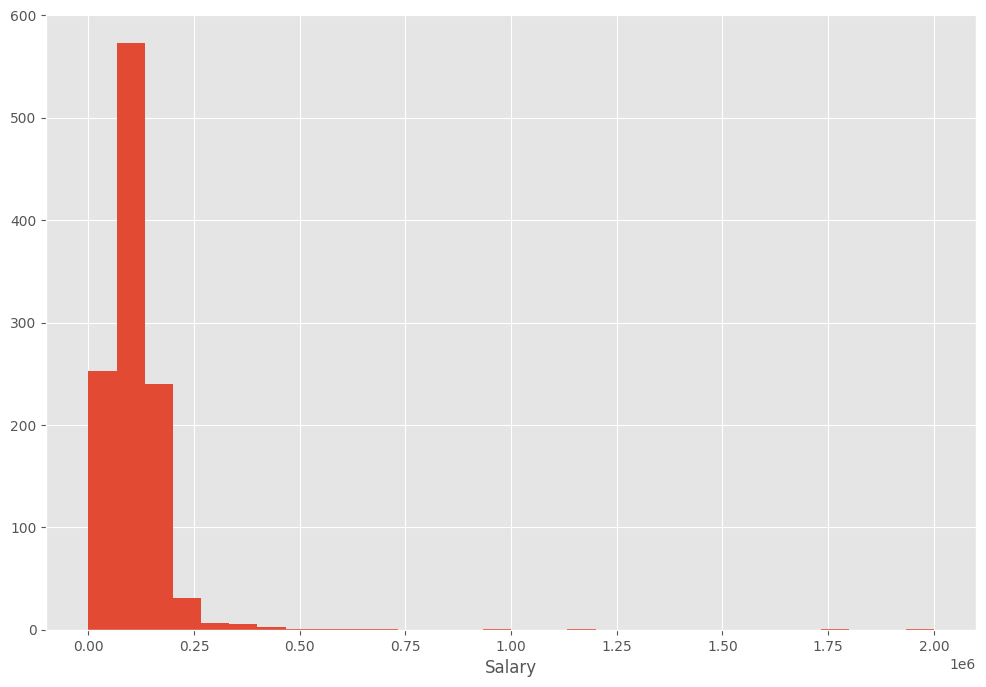

In [5]:
plt.hist(SALARIES, bins=30);
plt.xlabel('Salary');

There are a few outliers, and they're making it hard to see the shape of the distribution. If -- just for the plot -- we remove the salaries above $500,000, we see get a clearer picture:

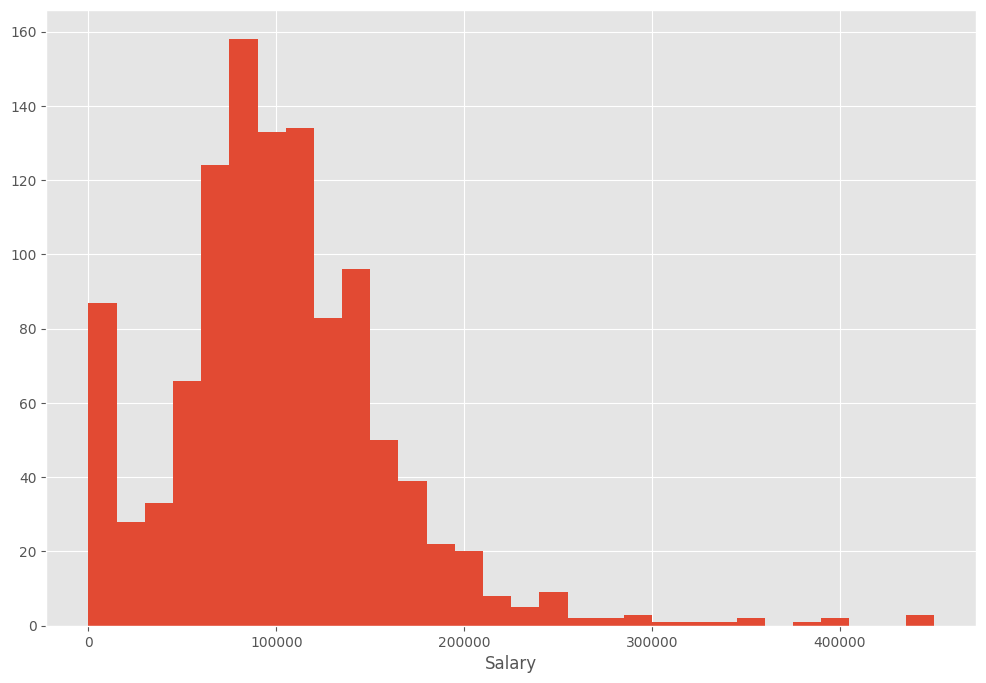

In [6]:
plt.hist(SALARIES[SALARIES < 500_000], bins=30);
plt.xlabel('Salary');

It looks like the "center" of the distribution is around $100,000. In fact, the mean is:

np.mean(SALARIES)

and the median is:

In [7]:
np.median(SALARIES)

100000.0

## 3. Example: Minimizing the mean squared error

Let's make our first prediction by minimizing the mean squared error.

Recall that the squared loss is $L_\text{sq}(h,y) = (y-h)^2$. Given a data set of numbers, $y_1, \ldots, y_n$, the **empirical risk** associated with this loss is:
$$
    R_\text{sq}(h) = \frac1n \sum_{i=1}^n L_\text{sq}(h,y_i)
    =
    \frac1n \sum_{i=1}^n (y_i - h)^2
$$
When the squared loss is used, the empirical risk is also known as the **mean squared error**. We saw in Lecture 3 that the mean squared error is directly minimized by the **mean**.

But we can also minimize the mean squared error with gradient descent. Why would we do this, given that we have a nice, simple formula for the minimizer? In truth, we wouldn't. But in coming weeks we will see situations where we also have a formula for the minimizer, but we decide to use gradient descent instead. In those situations, it turns out that gradient descent is computationally faster.

To begin, let's plot the mean squared error (MSE) for a range of predictions. We start by defining a function that computes the MSE for any possible prediction

In [8]:
@np.vectorize
def mean_squared_error(h):
    # YOUR IMPLEMENTATION IS HERE
    data = np.array(SALARIES)
    return np.mean((h - data) * (h - data))

For example, the MSE of predicting $h = \$100{,}000$ is:

In [9]:
mean_squared_error(100_000)

array(1.21230714e+10)

We'll evaluate the MSE on each of 1,000 possible predictions, from $\$25{,}000$ to $\$200{,}000$, and plot the empirical risk.
We'll also include the histogram of the data in the background so that we can see how the MSE relates to the data's distribution.

In [10]:
possible_predictions = np.linspace(25_000, 200_000, 1_000)

In [11]:
def plot_risk_and_histogram(risk, y_label='MSE'):
    fig, ax1 = plt.subplots()

    ax1.hist(SALARIES[SALARIES<300_000], bins=20, alpha=.5, zorder=1)

    ax2 = ax1.twinx()
    ax2.grid(False)
    ax2.plot(possible_predictions, risk(possible_predictions), color='black', zorder=20)
    plt.xlabel('Prediction')
    plt.ylabel(y_label)

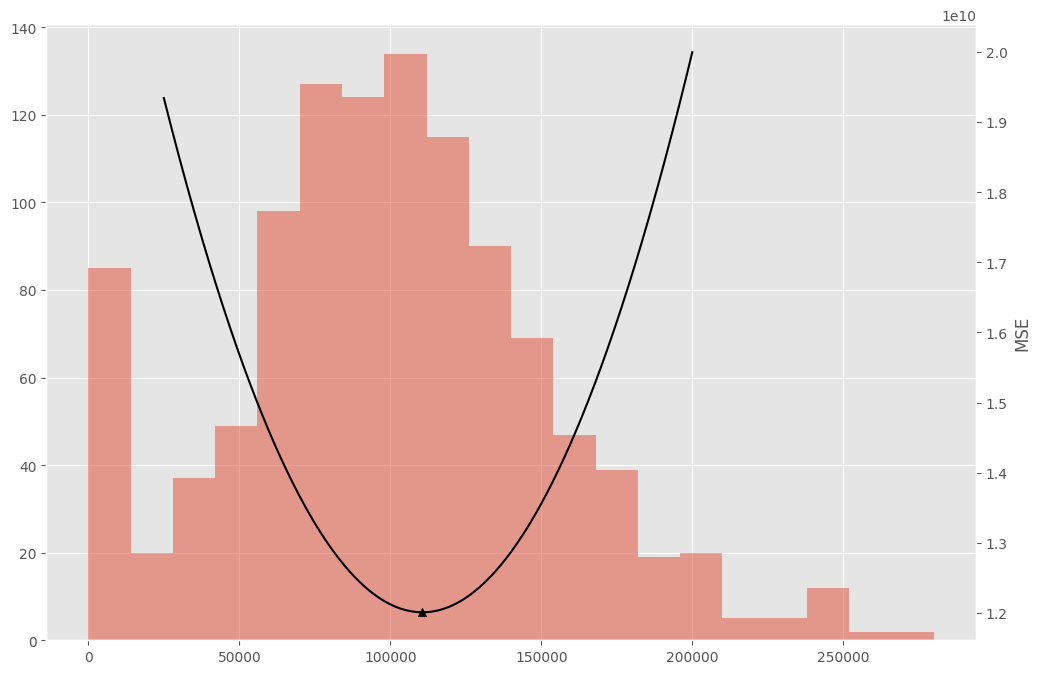

In [12]:
plot_risk_and_histogram(mean_squared_error)
plt.scatter(np.mean(SALARIES), mean_squared_error(np.mean(SALARIES)), color='black', marker='^');

The mean of the salaries is shown as the black triangle. As we expected, the minimizer of the mean squared error is indeed the mean. But instead of computing the mean directly, let's minimize this function using gradient descent.

To do so, we need a function which returns the derivative of $R_\text{sq}$ at any given place. Recall that the derivative of $R_\text{sq}$ with respect to $h$ is:

$$
    \frac{dR_\text{sq}}{dh}(h)
    =
    \frac{2}{n}
    \sum_{i=1}^n
        (h - y_i)
$$

Let's code this up:

In [13]:
@np.vectorize
def derivative_of_mean_squared_error(h):
    # YOUR IMPLEMENTATION IS HERE
    data = np.array(SALARIES)
    return 2.0 * np.mean(h - data)

Now we can calculate the derivative of the MSE at any point:

In [14]:
derivative_of_mean_squared_error(100_000)

array(-21272.94561998)

To check that we got the derivative right, we can check that it gives the right slope. The cell below defined a couple of helper functions which use `derivative_of_mean_squared_error` to plot the tangent line the the MSE at any point we choose. If the derivative is correct, we should see a line that is indeed tangent to the MSE:

In [15]:
from utils import plot_tangent_line

In [16]:
plot_tangent_line(
    f=mean_squared_error,
    f_prime=derivative_of_mean_squared_error,
    interval_size=30_000,
    domain=possible_predictions,
);

interactive(children=(FloatSlider(value=25000.0, continuous_update=False, description='h', max=200000.0, min=2…

Looks good! We know have everything we need to run gradient descent. We'll start with a step size of $\alpha = .1$, and we'll use $h_0 = 60{,}000$ as our starting position:

In [17]:
gradient_descent(
    derivative_of_mean_squared_error,
    h_0=60_000,
    alpha=.1,
    verbose=True,
    tol=.001,
)

110636.46854387668

This is pretty close to the mean:

In [18]:
np.mean(SALARIES)

110636.47280999109

If we let gradient descent run for even longer it would get arbitrarily close to the mean. So we have successfully computed the mean without using the formula for the mean.

You should try with different starting points, learning rate and tolerance.

In [19]:
# YOUR IMPLEMENTATION IS HERE
gradient_descent(
    derivative_of_mean_squared_error,
    h_0=70_000,
    alpha=.11,
    verbose=True,
    tol=.0001,
)

110636.47238934525

In [20]:
# YOUR IMPLEMENTATION IS HERE
gradient_descent(
    derivative_of_mean_squared_error,
    h_0=100_000,
    alpha=.1,
    verbose=True,
    tol=.00001,
)

110636.4727607263